In [4]:
import pandas as pd
import sklearn
from sklearn.base import TransformerMixin
from sklearn_pandas import DataFrameMapper, cross_val_score
import seaborn as sns
import matplotlib

In [12]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [5]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


**PassengerId** - irrelevant in terms of features <br>
**Survived** - "1" if survived, "0" otherwise <br>
**Pclass** - one of three classes (1,2,3) <br>
**Name** - name of a passenger including their titles<br>
**Sex** - male or female<br>
**Age** - age in years <br>
**SibSp** - number of passenger's siblings and spauses travelling with them<br>
**Parch** - number of passenger's parents and children travelling with them<br>
**Ticket** - ticket number<br>
**Fare** - fare<br>
**Cabin** - letters encode deck number and numbers encode cabin number <br>

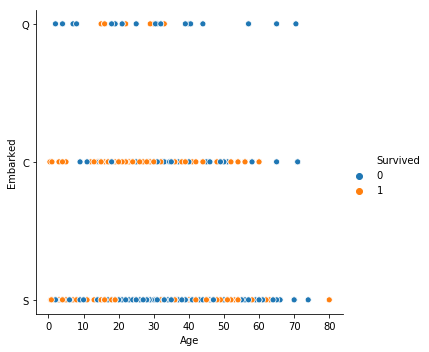

In [11]:
sns.relplot(x="Age", y="Embarked", hue="Survived", data=train)

In [20]:
class TitleEncoder(TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed = X.copy()
        for i in range(len(X)):
            transformed[i] = X[i].split(',')[1].split('.')[0]
        return transformed

In [21]:
mapper = DataFrameMapper([
    #features
    ('Pclass', sklearn.preprocessing.LabelBinarizer()),
    ('Sex', sklearn.preprocessing.LabelBinarizer()),
    ('Name', TitleEncoder(), {'alias':'Title'}),
    #result
    ('Survived', None)
], input_df=True, df_out=True)

In [22]:
mapper.fit_transform(train.copy())

,Pclass_1,Pclass_2,Pclass_3,Sex,Title,Survived
0,0,0,1,1,Mr,0
1,1,0,0,0,Mrs,1
2,0,0,1,0,Miss,1
3,1,0,0,0,Mrs,1
4,0,0,1,1,Mr,0
5,0,0,1,1,Mr,0
6,1,0,0,1,Mr,0
7,0,0,1,1,Master,0
8,0,0,1,0,Mrs,1
9,0,1,0,0,Mrs,1
